# Assignment 4
## By: Christian Ivanov 260808189

I will first write a routine which reads the files and extracts the data

In [205]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import gridspec
from scipy.ndimage import gaussian_filter
import h5py
import json

In [206]:
def read_template(filename):
    dataFile=h5py.File(filename,'r')
    template=dataFile['template']
    th=template[0]
    tl=template[1]
    return th,tl

def read_file(filename):
    dataFile=h5py.File(filename,'r')
    dqInfo = dataFile['quality']['simple']
    qmask=dqInfo['DQmask'][...]

    meta=dataFile['meta']
    gpsStart=meta['GPSstart'].value
    utc=meta['UTCstart'].value
    duration=meta['Duration'].value
    strain=dataFile['strain']['Strain'].value
    dt=duration/len(strain)

    dataFile.close()
    return strain,dt,utc

Here, I have specified the path to the BBH_events_v3.json file, assuming the rest of the data files are in the same directory.

Since we are repeating the same calculations for each gravitational wave event, I will be for-looping the computations across each of the events for the rest of the assignment, storing all the important data into 2d arrays on which the first axis indicates the selected event (sorted chronologically by the date in their titles)

In [207]:
fnjson = 'C:/Users/Christian/Downloads/LOSC_Event_tutorial/BBH_events_v3.json'
events = json.load(open(fnjson,"r"))

event = []
strain_H =[]
strain_L =[]
template_H = []
template_L = []
dt = []
utc = []
time = []
frequency = []

eventnames = ['GW150914','LVT151012','GW151226','GW170104']

for i in range(len(eventnames)):
    event.append(events[eventnames[i]])
    frequency.append(event[i]['fs'])
    
    strainh,dth,utch=read_file(event[i]['fn_H1'])
    strainl,dtl,utcl=read_file(event[i]['fn_L1'])
    th,tl=read_template(event[i]['fn_template'])
    
    strain_H.append(strainh)
    strain_L.append(strainl)
    template_H.append(th)
    template_L.append(tl)
    
    dt.append(dth)
    utc.append(utch)
    time.append(np.linspace(0,len(strain_H[i])/frequency[i],len(strain_H[i])))

To get a feel for what data we are dealing with, I will plot the strain overlaped by the template for each event. 

Note that the strain data for the Livingston detector is shifted down by what appears to be $10^-18$ for GW150914, LVT151012 and GW151226 and $1.5 \times 10^-18$ for GW170104, which I am assuming is done on purpose so it can be plotted alongside the Hansford data easier. This makes no difference, as in fourrier space, it translates to an ultra-low frequency bump which will be windowed away regardless, and so I have corrected for it in my plots below.

Since there are a lot of plots in this assignment, I played around with color schemes to make them easier and more intuitive to look at.

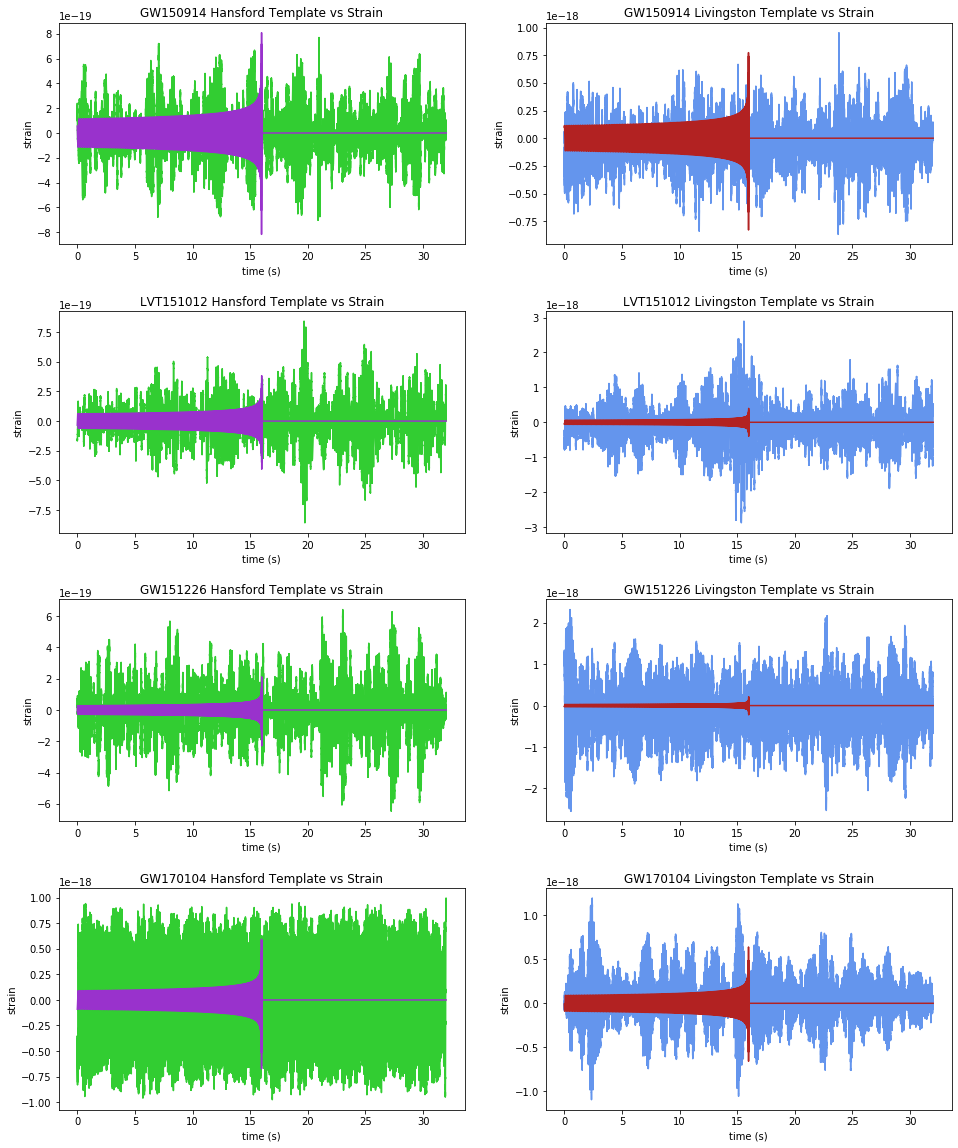

In [208]:
data = plt.figure(figsize=(16,20))
spec = gridspec.GridSpec(ncols=2, nrows=len(eventnames), figure=data,hspace=0.3)

for i in range(len(eventnames)):
    data.add_subplot(spec[i, 0])
    plt.plot(time[i],strain_H[i],color='limegreen')
    plt.plot(time[i],template_H[i],color='darkorchid')
    plt.title(eventnames[i]+' Hansford Template vs Strain')
    plt.xlabel("time (s)")
    plt.ylabel('strain')
    
    data.add_subplot(spec[i, 1])
    if i == 3:
        plt.plot(time[i],strain_L[i]+1.5e-18,color='cornflowerblue')
    else:
        plt.plot(time[i],strain_L[i]+1e-18,color='cornflowerblue')
    plt.plot(time[i],template_L[i],color='firebrick')
    plt.title(eventnames[i]+' Livingston Template vs Strain')
    plt.xlabel("time (s)")
    plt.ylabel('strain')

As we can see, the data in every single case is completely dominated by noise of all frequencies. Some events apear more masked by noise than others and will probably be more difficult to detect. In any case, it is clear that a lot of signal processing will be needed.

## Question 1
### (a)

I will start by defining a quick windowing funtion, since I will be using it often. I chose Numpy's integrated Blackman window, since it seems to give great results

In [209]:
def window(f):
    win = np.blackman(len(f))
    return f*win

I will start by assuming that the noise is stationary. The more-or-less uniform noise in the plots above suggest this is a somewhat reasonable assumption on the timerscales of the events. In this case, the noise model, $N$, in fourrier space is diagonal and it is equal to the square of the power spectrum of the strain, given by $N = \langle \mathscr{F}(strain)^2 \rangle$ where the brackets denote that it is smoothened-out.

Before jumping to fourrier space, I window both the strain and the filter, as they are discontinuous at their ends and would otherwise snduce significant ringing artifacts. I will use a Gaussian filter for the smoothing, a width of 4 seems to give good results. Note that since the noise matrix is diagonal, I can treat it as an array, which simplifies s lot of the computations.

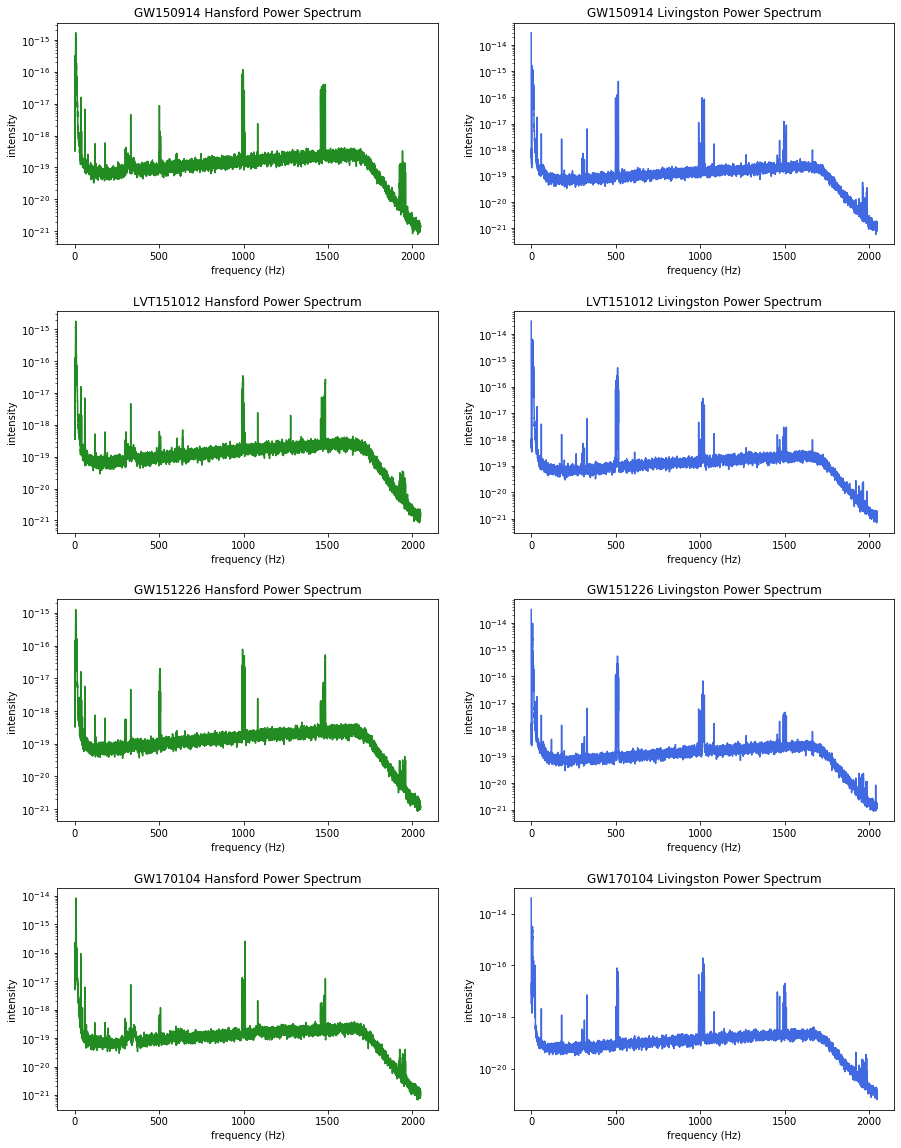

In [210]:
ft_strain_H = []
ft_strain_L = []
ft_template_H = []
ft_template_L = []
N_H = []
N_L = []

power_spectra = plt.figure(figsize=(15,20))
spec = gridspec.GridSpec(ncols=2, nrows=len(eventnames), figure=power_spectra, hspace=0.3)

for i in range(len(eventnames)):
    fstrain = np.fft.rfft(window(strain_H[i]))
    ftemplate = np.fft.rfft(window(template_H[i]))
    Pxx2 = np.abs(fstrain)**2
    Pxx2 = gaussian_filter(Pxx2,4)
    Pxx = np.sqrt(Pxx2)
    
    freq = np.fft.rfftfreq(len(strain_H[i]),dt[i])
    power_spectra.add_subplot(spec[i, 0])
    plt.semilogy(freq,Pxx,color='forestgreen')
    plt.title(eventnames[i]+' Hansford Power Spectrum')
    plt.xlabel("frequency (Hz)")
    plt.ylabel('intensity')
    
    ft_strain_H.append(fstrain)
    ft_template_H.append(ftemplate)
    N_H.append(Pxx2)
    
    fstrain = np.fft.rfft(window(strain_L[i]))
    ftemplate = np.fft.rfft(window(template_L[i]))
    Pxx2 = np.abs(fstrain)**2
    Pxx2 = gaussian_filter(Pxx2,4)
    Pxx = np.sqrt(Pxx2)
    
    freq = np.fft.rfftfreq(len(strain_L[i]),dt[i])
    power_spectra.add_subplot(spec[i, 1])
    plt.semilogy(freq,Pxx,color='royalblue')
    plt.title(eventnames[i]+' Livingston Power Spectrum')
    plt.xlabel("frequency (Hz)")
    plt.ylabel('intensity')
    
    ft_strain_L.append(fstrain)
    ft_template_L.append(ftemplate)
    N_L.append(Pxx2)

In the semi-log plots, we see that the power spectra (and thus noise models) of all the detections are more or less the same: for most of the spectrum, the Noise is flat (abeit with some spikes here and there). There is a large spike at very low frequencies (fft artefact since our data is finite) and a gradual drop-off above 1700Hz, but since we are working with windowed data, these are irrelevant.

## (b)

Before applying a matched filter, we need to Pre-whiten our data. The matched filter is $m = (A^T N^{-1} d)(A^T N^{-1} A)^{-1}$ where $A$ is the template and $d$ is the strain data. Note that because the noise is diagonal, then we have 
$m = ((N^{\frac{-1}{2}} A)^T I (N^{\frac{-1}{2}} d))((N^{\frac{-1}{2}} A)I(N^{\frac{-1}{2}} A))^{-1}$ and thus, in real-space, we have $ m = \mathscr{F}^{-1}((N^{\frac{-1}{2}} A) \times (N^{\frac{-1}{2}} d)^{\dagger})$ which gives us:

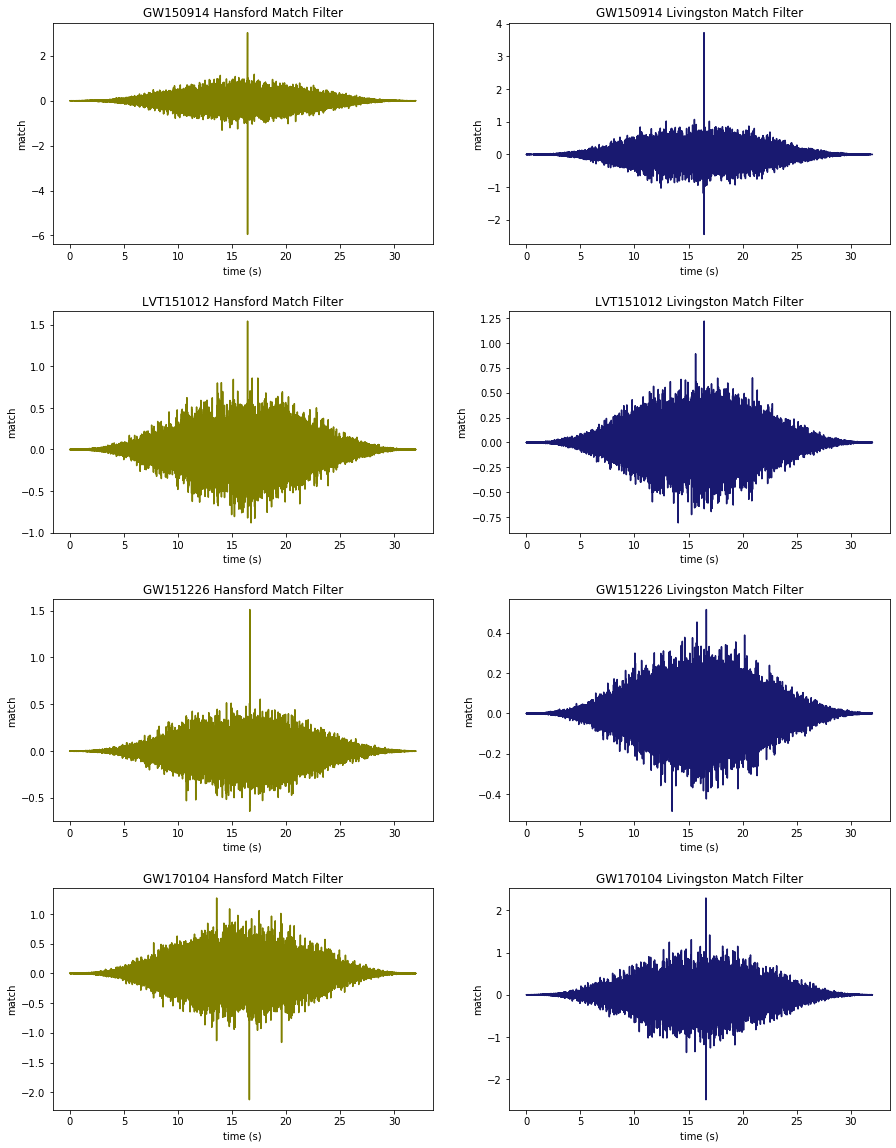

In [211]:
white_ft_template_H = []
white_ft_template_L = []
match_H = []
match_L = []

match_filters = plt.figure(figsize=(15,20))
spec = gridspec.GridSpec(ncols=2, nrows=len(eventnames), figure=match_filters, hspace=0.3)

for i in range(len(eventnames)):
    white_ft_strain = ft_strain_H[i]/np.sqrt(N_H[i])
    white_ft_template = ft_template_H[i]/np.sqrt(N_H[i])
    match = np.fft.irfft(white_ft_strain*np.conj(white_ft_template))
    match = np.fft.fftshift(match)
    
    match_filters.add_subplot(spec[i, 0])
    plt.plot(time[i],match,color='olive')
    plt.title(eventnames[i]+' Hansford Match Filter')
    plt.xlabel("time (s)")
    plt.ylabel("match")
    
    match_H.append(match)
    white_ft_template_H.append(white_ft_template)
    
    white_ft_strain = ft_strain_L[i]/np.sqrt(N_L[i])
    white_ft_template = ft_template_L[i]/np.sqrt(N_L[i])
    match = np.fft.irfft(white_ft_strain*np.conj(white_ft_template))
    match = np.fft.fftshift(match)
    
    match_filters.add_subplot(spec[i, 1])
    plt.plot(time[i],match,color='midnightblue')
    plt.title(eventnames[i]+' Livingston Match Filter')
    plt.xlabel("time (s)")
    plt.ylabel("match")
    
    match_L.append(match)
    white_ft_template_L.append(white_ft_template)

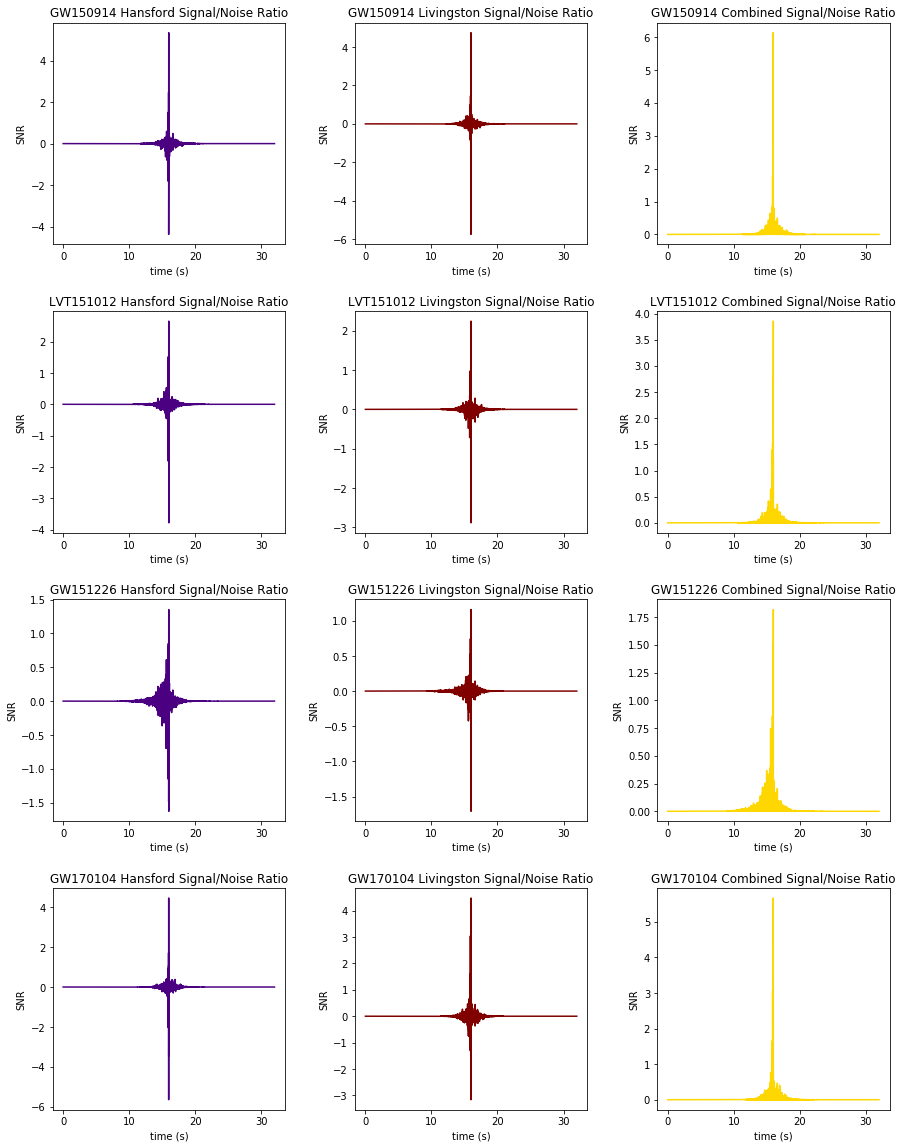

In [212]:
SNRs = plt.figure(figsize=(15,20))
spec = gridspec.GridSpec(ncols=3, nrows=len(eventnames), figure=SNRs, hspace=0.3, wspace=0.3)

for i in range(len(eventnames)):

    white_template = np.fft.irfft(white_ft_template_H[i])
    SNR_H = match*np.sqrt(white_template*np.conj(white_template))

    SNRs.add_subplot(spec[i, 0])
    plt.plot(time[i],SNR_H,color='indigo')
    plt.title(eventnames[i]+' Hansford Signal/Noise Ratio')
    plt.xlabel("time (s)")
    plt.ylabel("SNR")
    
    white_template = np.fft.irfft(white_ft_template_L[i])
    SNR_L = match*np.sqrt(white_template*np.conj(white_template))

    SNRs.add_subplot(spec[i, 1])
    plt.plot(time[i],SNR_L,color='maroon')
    plt.title(eventnames[i]+' Livingston Signal/Noise Ratio')
    plt.xlabel("time (s)")
    plt.ylabel("SNR")
    
    SNR_Combined = np.sqrt(SNR_H**2 + SNR_L**2)
    
    SNRs.add_subplot(spec[i, 2])
    plt.plot(time[i],SNR_Combined,color='gold')
    plt.title(eventnames[i]+' Combined Signal/Noise Ratio')
    plt.xlabel("time (s)")
    plt.ylabel("SNR")

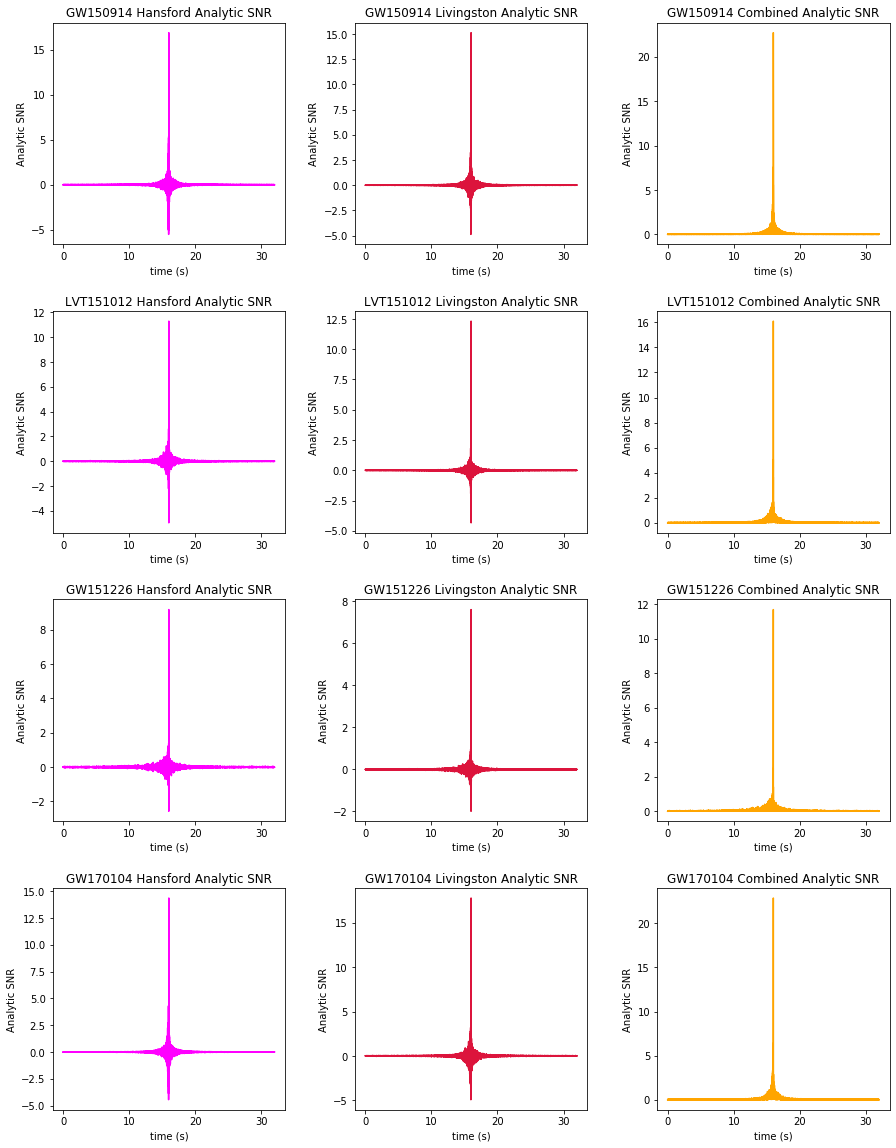

In [213]:
SNRs_analytic = plt.figure(figsize=(15,20))
spec = gridspec.GridSpec(ncols=3, nrows=len(eventnames), figure=SNRs_analytic, hspace=0.3,wspace=0.3)

for i in range(len(eventnames)):
    ft_SNR_H = np.sqrt(ft_template_H[i]**2/N_H[i])
    SNR_H = np.fft.irfft(ft_SNR_H)
    SNR_H = np.fft.fftshift(SNR_H)
    
    SNRs_analytic.add_subplot(spec[i, 0])
    plt.plot(time[i],SNR_H,color='fuchsia')
    plt.title(eventnames[i]+' Hansford Analytic SNR')
    plt.xlabel("time (s)")
    plt.ylabel("Analytic SNR") 
    
    ft_SNR_L = np.sqrt(ft_template_L[i]**2/N_L[i])
    SNR_L = np.fft.irfft(ft_SNR_L)
    SNR_L = np.fft.fftshift(SNR_L)
    
    SNRs_analytic.add_subplot(spec[i, 1])
    plt.plot(time[i],SNR_L,color='crimson')
    plt.title(eventnames[i]+' Livingston Analytic SNR')
    plt.xlabel("time (s)")
    plt.ylabel("Analytic SNR") 
    
    SNR_Combined = np.sqrt(SNR_H**2 + SNR_L**2)
    
    SNRs_analytic.add_subplot(spec[i, 2])
    plt.plot(time[i],SNR_Combined,color='orange')
    plt.title(eventnames[i]+' Combined Analytic SNR')
    plt.xlabel("time (s)")
    plt.ylabel("Analytic SNR")

In [214]:
for i in range(len(eventnames)):
    Pxx_template = np.abs(white_ft_template_H[i])**2
    Pxx_template = gaussian_filter(Pxx_template,10)
    sum_H = np.cumsum(Pxx_template)/np.sum(Pxx_template)
    midpoint_H = np.argmin(np.abs(sum_H-0.5))
    midpoint_H = np.fft.rfftfreq(len(strain_H[i]),dt[i])[midpoint_H]
    
    Pxx_template = np.abs(white_ft_template_L[i])**2
    Pxx_template = gaussian_filter(Pxx_template,10)
    sum_L = np.cumsum(Pxx_template)/np.sum(Pxx_template)
    midpoint_L = np.argmin(np.abs(sum_L-0.5))
    midpoint_L = np.fft.rfftfreq(len(strain_L[i]),dt[i])[midpoint_L]
    
    print('Half-Power frequency of',eventnames[i],'is:',midpoint_H,'Hz for Hansford and',midpoint_L,'Hz for Livingston')

Half-Power frequency of GW150914 is: 102.4375 Hz for Hansford and 115.25 Hz for Livingston
Half-Power frequency of LVT151012 is: 79.28125 Hz for Hansford and 97.3125 Hz for Livingston
Half-Power frequency of GW151226 is: 77.53125 Hz for Hansford and 107.5 Hz for Livingston
Half-Power frequency of GW170104 is: 91.75 Hz for Hansford and 76.09375 Hz for Livingston
